In [1]:
import sys
from fitparse import FitFile

import pandas as pd
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
filename = './WEMBLEY_WHEELSPIN.fit'
filename = './Wahoo_RGT_Moonriders_Heroica_4_2.fit'
filename = './Zwift_Race_3R_Racing_A_on_Tick_Tock_in_Watopia.fit'
filename = './Zwift_Race_STAGE_3_RACE_LONDON_London_Classique_Reverse_A_on_Classique_Reverse_in_London.fit'
filename = "./Etoile_des_Saisies_.fit"
#filename = "./HILLINGDON_CIRCUIT_.fit"$
filename = "./seyssinet_1.fit"
filename = "./Classico_gravel.fit"

fitfile = FitFile(filename)
while True:
    try:
        fitfile.messages
        break
    except KeyError:
        continue
workout = []
for record in fitfile.get_messages('record'):
    r = {}
    for record_data in record:
        r[record_data.name] = record_data.value
    workout.append(r)


def fit2df(filename):
    fitfile = FitFile(filename)
    while True:
        try:
            fitfile.messages
            break
        except KeyError:
            continue
    workout = []
    for record in fitfile.get_messages('record'):
        r = {}
        for record_data in record:
            r[record_data.name] = record_data.value
        workout.append(r)
    return pd.DataFrame(workout)

df = fit2df(filename)

In [3]:
df.columns

Index(['altitude', 'distance', 'enhanced_altitude', 'temperature', 'timestamp',
       'unknown_61', 'unknown_66', 'power', 'accumulated_power', 'cadence',
       'fractional_cadence', 'left_pco', 'left_power_phase',
       'left_power_phase_peak', 'right_pco', 'enhanced_speed', 'position_lat',
       'position_long', 'speed', 'left_right_balance', 'right_power_phase',
       'right_power_phase_peak'],
      dtype='object')

In [4]:
df.groupby('left_power_phase_peak').size()

left_power_phase_peak
(26.718750417480475, 42.1875006591797)      1
(37.96875059326173, 102.65625160400393)     1
(39.375000615234384, 43.59375068115236)     1
(40.781250637207044, 95.62500149414065)     2
(40.781250637207044, 99.84375156005862)     1
                                           ..
(111.09375173583987, 112.50000175781253)    2
(111.09375173583987, 127.96875199951175)    2
(112.50000175781253, 120.93750188964847)    1
(113.90625177978518, 122.34375191162113)    2
(185.62500290039068, 151.87500237304693)    3
Length: 397, dtype: int64

In [5]:
for col in df.columns:
    if df[col].isnull().all():
        df.drop(col, axis=1, inplace = True)
        print(f"Drop {col}")

In [6]:
df.position_lat / 11930465 

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
5096    45.193558
5097    45.193559
5098    45.193559
5099    45.193561
5100    45.193563
Name: position_lat, Length: 5101, dtype: float64

In [7]:
from math import sin, cos, sqrt, atan2, radians

# Approximate radius of earth in km
R = 6373.0

lat1 = radians(52.2296756)
lon1 = radians(21.0122287)
lat2 = radians(52.406374)
lon2 = radians(16.9251681)

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

print("Result: ", distance)
print("Should be: ", 278.546, "km")



def distance_gpx(lat1, lon1, lat2, lon2):
    #print(lat1, lon1, lat2, lon2)
    if (lat2 or lon2 or lat1 or lon1) == None:
        return 0
        # Convert latitude and longitude to degrees
    lat1 = radians(lat1 * (180 / 2 ** 31) )
    lat2 = radians(lat2 * (180 / 2 ** 31) )
    lon1 = radians(lon1 * (180 / 2 ** 31)) 
    lon2 = radians(lon2 * (180 / 2 ** 31) )
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return c * R * 1000

distance_gpx(lat1, lon1, lat2, lon2)



Result:  278.54558935106695
Should be:  278.546 km


0.0006656682930812785

In [8]:
df['timestep'] = df.timestamp-df.timestamp.shift()
df['elevation_gain'] = df.altitude-df.altitude.shift()
df['acceleration'] = df.speed-df.speed.shift()
df['dist_diff'] = df.distance-df.distance.shift()


In [9]:
df.iloc[:2]

,altitude,distance,enhanced_altitude,temperature,timestamp,unknown_61,unknown_66,power,accumulated_power,cadence,...,position_lat,position_long,speed,left_right_balance,right_power_phase,right_power_phase_peak,timestep,elevation_gain,acceleration,dist_diff
0,226.2,0.0,226.2,21,2023-06-12 09:56:45,3631,578,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,224.8,0.0,224.8,21,2023-06-12 09:56:49,3624,577,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:04,-1.4,NaN,0.0


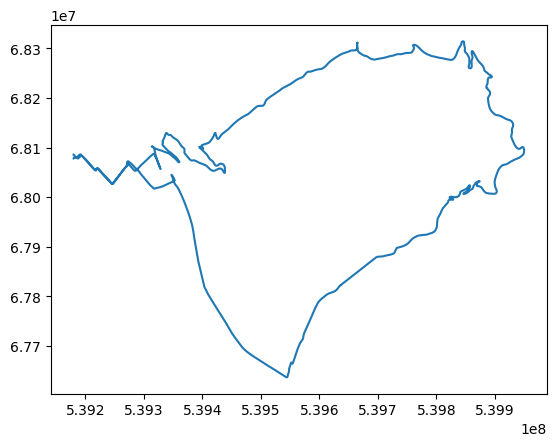

In [10]:
%matplotlib inline
plt.plot(df.position_lat, df.position_long)
plt.show()

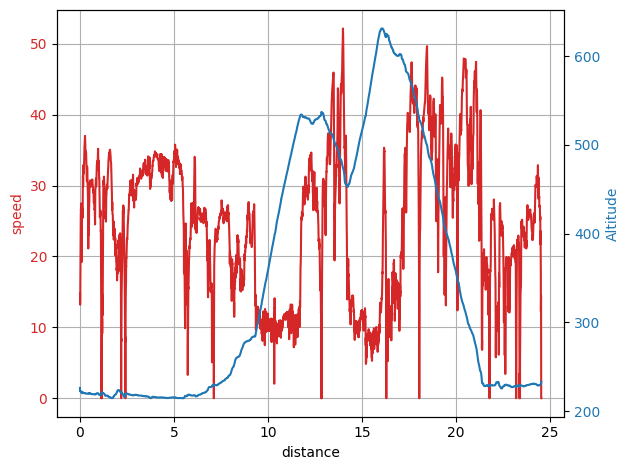

In [11]:
fig, ax1 = plt.subplots()
plt.grid()
color = 'tab:red'
ax1.set_xlabel('distance')
ax1.set_ylabel('speed', color=color)
ax1.plot(df.distance/1000, df.speed*3.6, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Altitude', color=color)  # we already handled the x-label with ax1
ax2.plot(df.distance/1000, df.altitude, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

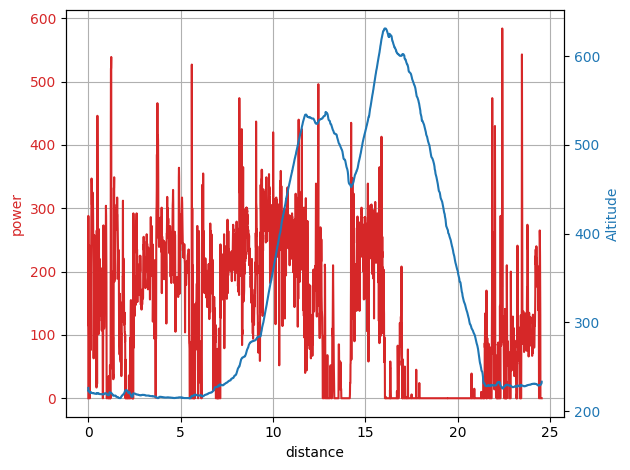

In [12]:
%matplotlib inline
fig, ax1 = plt.subplots()
plt.grid()
color = 'tab:red'
ax1.set_xlabel('distance')
ax1.set_ylabel('power', color=color)
ax1.plot(df.distance/1000, df.power, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Altitude', color=color)  # we already handled the x-label with ax1
ax2.plot(df.distance/1000, df.altitude, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [13]:
df["pos_lat1"] = df.position_lat.shift(fill_value=0)
df["pos_long1"] = df.position_long.shift(fill_value=0)

In [14]:
df["distance_comp"] = df.apply(lambda x: distance_gpx(x.position_lat, x.position_long, x.pos_lat1, x.pos_long1), axis = 1)
df[["distance", "dist_diff","distance_comp", "position_lat", "position_long"]]

,distance,dist_diff,distance_comp,position_lat,position_long
0,0.00,NaN,NaN,NaN,NaN
1,0.00,0.00,NaN,NaN,NaN
2,0.00,0.00,NaN,NaN,NaN
3,0.00,0.00,NaN,NaN,NaN
4,0.00,0.00,NaN,NaN,NaN
...,...,...,...,...,...
5096,24552.38,0.03,0.365750,539180161.0,68078487.0
5097,24552.38,0.00,0.155909,539180170.0,68078467.0
5098,24552.54,0.16,0.387752,539180169.0,68078408.0
5099,24552.54,0.00,0.300613,539180198.0,68078388.0


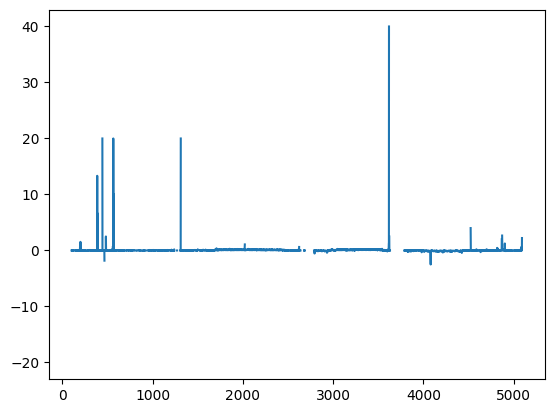

In [15]:
df["slope"] = df.elevation_gain / df.dist_diff
df[["slope", "dist_diff"]]
plt.plot(df.slope[100:])

In [16]:
df[['acceleration', 'speed']]

,acceleration,speed
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
5096,0.0,0.0
5097,0.0,0.0
5098,0.0,0.0
5099,0.0,0.0


In [2]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw_idle()

interact(update);

In [17]:
df["gravity_power"] = 9.81 * df.elevation_gain * m 
df[['gravity_power', "speed", 'elevation_gain']].iloc[40:60]

NameError: name 'm' is not defined

In [ ]:
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

True

In [ ]:
df.timestamp[1:].dtypes

dtype('<M8[ns]')

In [ ]:
( df.timestamp[1:] - df.timestamp[:-1]).astype('timedelta64[s]')

0         NaT
1      0 days
2      0 days
3      0 days
4      0 days
        ...  
1616   0 days
1617   0 days
1618   0 days
1619   0 days
1620      NaT
Name: timestamp, Length: 1621, dtype: timedelta64[s]

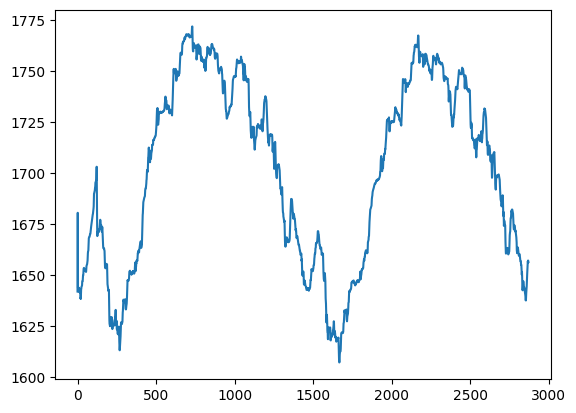

In [15]:
plt.plot(df.altitude)

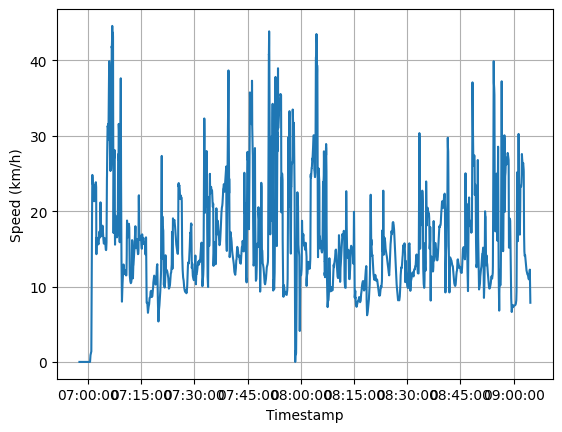

In [16]:
plt.plot(df.timestamp, df.speed*3.6)
plt.xlabel("Timestamp")
plt.ylabel("Speed (km/h)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.grid()
plt.show()

In [17]:
plt.figure()
plt.plot(df.power, label = "power")
plt.plot(df.altitude/10, label = "altitude")
plt.grid()
plt.plot(df.heart_rate, label = 'heart')
plt.legend()
#plt.ylim([140,180])
plt.show()

AttributeError: 'DataFrame' object has no attribute 'power'

<Figure size 640x480 with 0 Axes>

# Bike power maths
## 3 components

1. Gravity

$P_{gravity} = v_h \times g \times m = g \times slope \times v \times m$

2. Fluid resistance

$P_{fluid} = 0.5 \times a_{cx} \times \rho \times v^3$

3. Shear resistance

$P_{shear} = r_x \times m \times v$

4. Cyclist
$P_{cyclist}$

In [111]:
# parameters
a_cx = 0.4891 # m^2 air resistance coeff
rx = 0.00330 # road-tyre friction coeff 
bike_w = 9 # in kgs
rider_w = 61 # in kgs
slope = 1 # %
m = bike_w + rider_w
vk = 40 # km/h
vm = vk / 3.6 # speed in m/s
vh = 0 # height speed in m/s
vh = vm * slope / 100
g  = 9.81 # Earth gravity
rho = 1.1839 # kg/m3 at 25C, sea level

P_air = 0.5 * a_cx * rho * vm * vm * vm
P_roll = rx * vm  * m * g
P_g = m * vh * g 
# P_a = m * dv / dt

In [112]:
def P_air(v, a_cx, rho):
    return 0.5 * a_cx * rho * v * v * v

def P_gravity(v, slope, m):
    return g * v * slope/100 * m

def P_shear(v, rx, m):
    return v * rx * m * g


In [128]:
df["f_cyclist"] = df.power / m /df.speed
df["f_weight"] = g * 


df["f_shear"] = - rx
df["f_air"] = df.speed * df.speed * 0.5 * a_cx * rho

In [113]:
df["gravity_power"] = g * df.elevation_gain * m 

,gravity_power,speed,elevation_gain
40,0.00,11.587,0.0
41,-137.34,11.785,-0.2
42,-274.68,12.104,-0.4
43,-412.02,12.560,-0.6
44,-412.02,13.056,-0.6
45,-549.36,13.506,-0.8
46,-274.68,13.813,-0.4
47,0.00,13.875,0.0
48,137.34,13.729,0.2
49,274.68,13.466,0.4


In [114]:
df["shear_power"] = df.apply(lambda x: P_air(x.speed, a_cx, rho), axis=1)

In [ ]:
df.air = df.apply(lambda x: P_air(x.speed, a_cx, rho), axis=1)
df.shear = df.apply(lambda x: P_shear(x.speed, rx, m), axis=1)

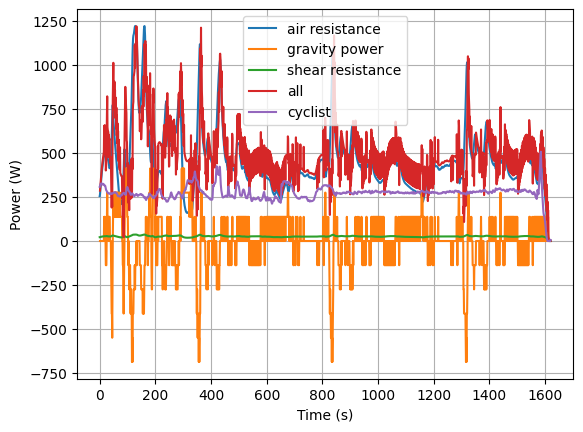

In [125]:

plt.plot(df.air, label = 'air resistance')
plt.plot(df.gravity_power, label = 'gravity power')
plt.plot(df.shear, label = 'shear resistance')
plt.plot(df.shear + df.gravity_power + df.air, label = "all")
plt.plot(df.power, label = "cyclist")
plt.legend()
plt.ylabel("Power (W)")
plt.xlabel("Time (s)")
plt.grid()
plt.show()

In [31]:
df.shear

0       21.718398
1       21.969936
2       22.436755
3       22.944364
4       23.451972
          ...    
1616     1.416319
1617     0.000000
1618     0.000000
1619     0.172224
1620     0.335384
Length: 1621, dtype: float64

In [6]:
def fit2df(filename):

    fitfile = FitFile(filename)
    while True:
        try:
            fitfile.messages
            break
        except KeyError:
            continue
    workout = []
    for record in fitfile.get_messages('record'):
        r = {}
        for record_data in record:
            r[record_data.name] = record_data.value
        workout.append(r)
    df = pd.DataFrame(workout)
    return df

In [7]:
def power_curve(df):
    x = np.logspace(0, np.log10(len(df)), 100, endpoint = False)
    power_curve = [df.power.rolling(int(nb)+1).mean().max() for nb in x]
    return x, power_curve

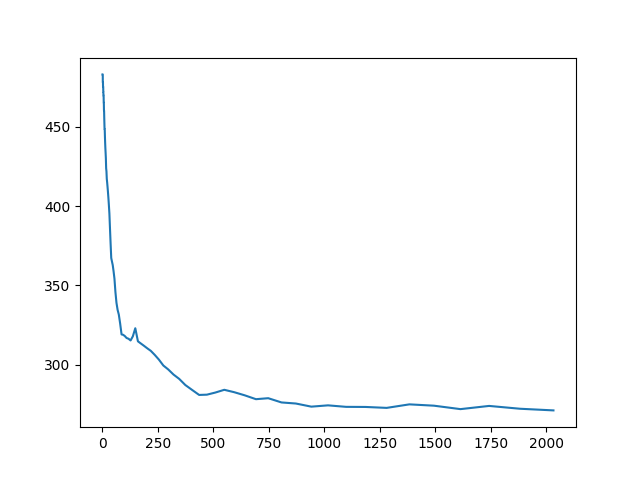

In [8]:
f = power_curve(fit2df(filename))
plt.plot(f[0], f[1])
plt.show()

In [9]:
df.columns

Index(['altitude', 'cadence', 'cycle_length', 'distance', 'enhanced_altitude',
       'enhanced_speed', 'fractional_cadence', 'heart_rate',
       'left_right_balance', 'position_lat', 'position_long', 'power', 'speed',
       'stance_time', 'stance_time_percent', 'temperature', 'timestamp',
       'vertical_oscillation', 'unknown_14', 'unknown_15'],
      dtype='object')

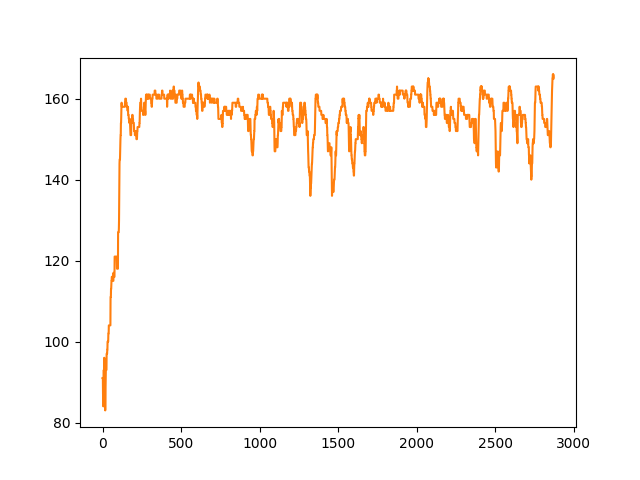

In [10]:
plt.figure()
plt.plot(df.power)
plt.plot(df.heart_rate)
plt.show()

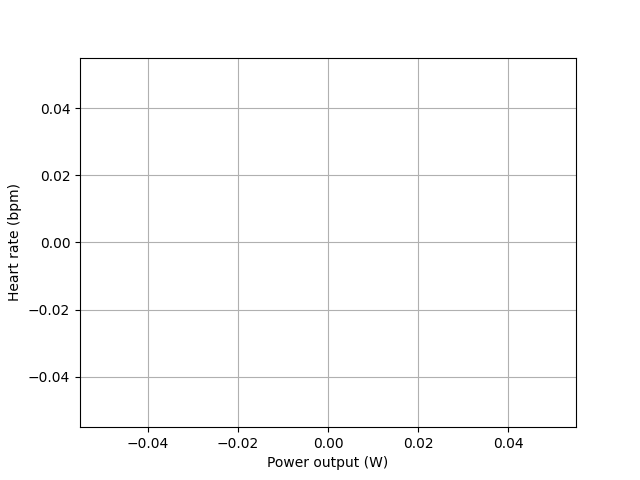

In [11]:
nb_periods = 15
cmap = plt.cm.get_cmap('viridis')
plt.figure()
for i, (pw, hr) in enumerate(zip(np.array_split(df.power, nb_periods), np.array_split(df.heart_rate, nb_periods))):
    plt.plot(pw, hr, 'x-', color=cmap(float(i/nb_periods)))
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Power output (W)")
#plt.title("Power map vs heart rate")
plt.grid()
plt.show()

In [12]:
def find_best(seri, nb_elts):
    max = 0
    for s in range(len(seri) - nb_elts):
        tmp = seri[s:s+nb_elts].mean()
        if tmp > max: 
            max = tmp
    return max
find_best(df.power, 10)

0

In [13]:
%timeit df.power.rolling(2).mean().max()

539 µs ± 41.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
df.power.rolling(10).mean().max()

nan

In [15]:
%timeit find_best(df.power, 2)

387 ms ± 36.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
x2 = np.logspace(0, np.log10(1679), 100, endpoint = False)

In [17]:
import numpy as np
x = np.logspace(0, np.log10(len(df.power)), 100, endpoint = False)

In [18]:
 # Calculate the time vector in seconds
time_data = np.cumsum([m.get_value('timestamp').time_from_start for m in power_messages])
time_data = time_data - time_data[0]

NameError: name 'power_messages' is not defined

In [19]:
power_curve_2 = [df.power.rolling(int(nb)+1).mean().max() for nb in x]

In [20]:
df.timestamp[0].strftime("%d/%m/%y")

'02/04/23'

In [23]:
filename = "./Zwift_Race_GGCC_Race_Series_B_on_The_Muckle_Yin_in_Scotland.fit"
filename = "./Wahoo_RGT_WEST_LONDON_VR_RACE_6_12_WEMBLEY_WHEELSPIN.fit"

# split the string by dot and get the first and last element
first_word, last_word = filename.split("_")[:1] + filename.split("_")[-1:]

print("First word:", first_word[2:])
print("Last word:", last_word[:-4])

def getfirstlast(filename):
    first_word, last_word = filename.split("_")[:1] + filename.split("_")[-1:]
    return first_word[2:] + " " + last_word[:-4]

getfirstlast(filename)


First word: Wahoo
Last word: WHEELSPIN


'Wahoo WHEELSPIN'

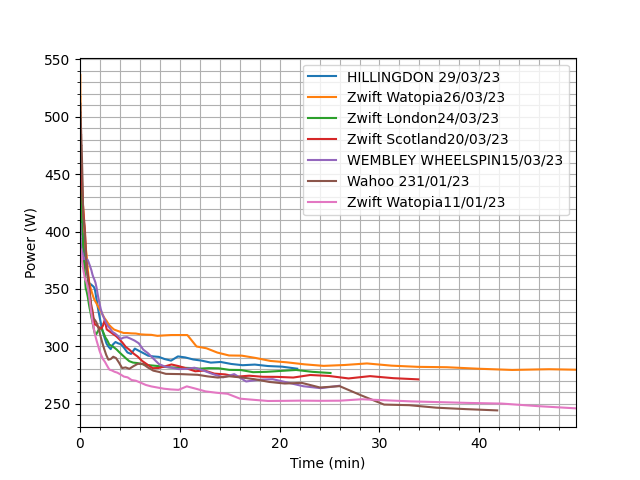

In [30]:
#%matplotlib inline
%matplotlib widget

filename = "./Zwift_Race_GGCC_Race_Series_B_on_The_Muckle_Yin_in_Scotland.fit"

filenames = ['./HILLINGDON_CIRCUIT_.fit','./Zwift_Race_After_Party_Race_by_PETA_Z_A_on_Volcano_Climb_After_Party_in_Watopia.fit','./Zwift_Race_STAGE_3_RACE_LONDON_London_Classique_Reverse_A_on_Classique_Reverse_in_London.fit',  './Zwift_Race_GGCC_Race_Series_B_on_The_Muckle_Yin_in_Scotland.fit', './WEMBLEY_WHEELSPIN.fit' ,'./Wahoo_RGT_Moonriders_Heroica_4_2.fit','./Zwift_Race_3R_Racing_A_on_Tick_Tock_in_Watopia.fit']

for fname in filenames:
    df = fit2df(fname)
    f = power_curve(df) 

    plt.plot(f[0]/60, f[1], label = getfirstlast(fname) + df.timestamp[0].strftime("%d/%m/%y"))


plt.xlabel("Time (min)")
plt.ylabel("Power (W)")
plt.legend()
plt.minorticks_on()
plt.xlim([0, f[0].max()/60])
plt.grid(which='both')

In [ ]:
ftp = 275
norm_power = np.sqrt(np.sqrt(np.mean(df['power'].rolling(30).mean() ** 4)))
intensity = norm_power / ftp
tss = (len(df.power) * norm_power * intensity) / (ftp * 3600.0) * 100.0
print('\n'
      'NP: {} W \n'
      'Training Stres S: {} \n'
      'Intensity Factor: {}'.format(str(round(norm_power, 1)), str(round(tss, 1)), str(round(intensity, 2))))

## Power model

$ H(t+1) = \frac{\alpha H(t) + \beta - P(t)}{\tau} $

where $ P = \alpha H + \beta $ in steady state.

In [ ]:
tau_r = 60 # recovery
tau_a = 60 # action
hr_idle = 50
hr_vo2max = 170
power_vo2max = 320


a = (hr_vo2max-hr_idle) / power_vo2max
alpha = 1/a
beta = -hr_idle/a

def hr_p(p):
    return hr_idle + a * p

def hr_t(hr, power, tau_a, tau_r, alpha, beta):
    power_th = alpha * hr + beta
    if power_th > power: # recovery
        tau = -tau_a
    else:
        tau = -tau_r
    return hr + (power_th - power) / tau


In [ ]:
hr = df.heart_rate[0]
print(hr)
hr_calc = []
for i in range(len(df[:])):
    new_hr = hr_t(hr, df.power[i], tau_a, tau_r, alpha, beta)
    hr_calc.append(new_hr)
    hr = new_hr

In [ ]:
plt.figure()
plt.plot(hr_calc, label= "calc")
plt.plot(df.heart_rate, label = "real")
plt.legend()
plt.grid()
plt.show()

In [ ]:
age = 43
height = 1.71
weight = 61

Pmax = (2160 * height - 9.63 * age + 4.0 * weight -2413) * 0.163
Pmax

In [ ]:
HRmax = 208 - 0.7 * age
HRmax